In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
chembert_model = AutoModelForSequenceClassification.from_pretrained("seyonec/ChemBERTa-zinc-base-v1", num_labels = 1)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/501 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/9.43k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/3.21k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/179M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 65.0 MB/s eta 0:00:00


In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 41.1 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np

import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from rdkit import Chem

import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, EarlyStoppingCallback

In [ ]:
CFG = {
    'NBITS':2048,
    'SEED':42,
    'BATCH_SIZE':32,
    'LR':0.0001,
    'EPOCHS':100,
    'DROPOUT':0.4,
    'PATIENCE':15  # 조기 종료 기준 증가
}

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(CFG['SEED']) # Seed 고정

In [ ]:
ROOT_DIR = '/content/drive/MyDrive/JUMP_AI_2024/Open/'

In [ ]:
train = pd.read_csv(os.path.join(ROOT_DIR, 'train.csv'))
test = pd.read_csv(os.path.join(ROOT_DIR, 'test.csv'))
train

,Molecule ChEMBL ID,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Assay ChEMBL ID,Target ChEMBL ID,Target Name,Target Organism,Target Type,Document ChEMBL ID,IC50_nM,pIC50,Smiles
0,CHEMBL4443947,IC50,'=',0.022,nM,10.66,CHEMBL4361896,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4359855,0.022,10.66,CN[C@@H](C)C(=O)N[C@H](C(=O)N1C[C@@H](NC(=O)CC...
1,CHEMBL4556091,IC50,'=',0.026,nM,10.59,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4342485,0.026,10.59,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
2,CHEMBL4566431,IC50,'=',0.078,nM,10.11,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4342485,0.078,10.11,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
3,CHEMBL4545898,IC50,'=',0.081,nM,10.09,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4342485,0.081,10.09,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
4,CHEMBL4448950,IC50,'=',0.099,nM,10.00,CHEMBL4361896,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4359855,0.099,10.00,COc1cc2c(OC[C@@H]3CCC(=O)N3)ncc(C#CCCCCCCCCCCC...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1947,CHEMBL380009,IC50,'=',30000.000,nM,4.52,CHEMBL870864,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL1147720,30000.000,4.52,O=C(Nc1nc2cc[nH]cc-2n1)c1cccc([N+](=O)[O-])c1
1948,CHEMBL377654,IC50,'=',30000.000,nM,4.52,CHEMBL870864,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL1147720,30000.000,4.52,CCCCn1c(NC(=O)c2cccc(Cl)c2)nc2ccccc21
1949,CHEMBL208667,IC50,'=',30000.000,nM,4.52,CHEMBL870864,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL1147720,30000.000,4.52,O=C(Nc1nc2cc(F)c(F)cc2[nH]1)c1cccc([N+](=O)[O-...
1950,CHEMBL3403453,IC50,'=',42000.000,nM,4.38,CHEMBL3407004,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL3400143,42000.000,4.38,OC[C@H]1C[C@@H](Nc2nc(Nc3ccccc3)ncc2-c2nc3cccc...


# GAT

In [ ]:
from rdkit.Chem import Descriptors, Lipinski

# def lipinski(smiles, verbose=False):

#     moldata= []
#     for elem in smiles:
#         mol=Chem.MolFromSmiles(elem)
#         moldata.append(mol)

#     baseData= np.arange(1,1)
#     i=0
#     for mol in moldata:

#         desc_MolWt = Descriptors.MolWt(mol)
#         desc_MolLogP = Descriptors.MolLogP(mol)
#         desc_NumHDonors = Lipinski.NumHDonors(mol)
#         desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

#         row = np.array([desc_MolWt,
#                         desc_MolLogP,
#                         desc_NumHDonors,
#                         desc_NumHAcceptors])

#         if(i==0):
#             baseData=row
#         else:
#             baseData=np.vstack([baseData, row])
#         i=i+1

#     columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]
#     descriptors = pd.DataFrame(data=baseData,columns=columnNames)

#     return descriptors

In [ ]:
# QSAR Descriptors
def calculate_qsar_descriptors(smiles_list):
    descriptor_names = [
        'MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors', 'NumRotatableBonds',
        'TPSA', 'HeavyAtomCount', 'NumValenceElectrons', 'RingCount'
    ]

    descriptors_list = []

    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            descriptors = [
                Descriptors.MolWt(mol),                # 분자량
                Descriptors.MolLogP(mol),              # LogP
                Lipinski.NumHDonors(mol),              # 수소 결합 기부체 수
                Lipinski.NumHAcceptors(mol),           # 수소 결합 수용체 수
                Descriptors.NumRotatableBonds(mol),    # 회전 가능한 결합 수
                Descriptors.TPSA(mol),                 # 상위 극성 표면적
                Descriptors.HeavyAtomCount(mol),       # 중원자 수
                Descriptors.NumValenceElectrons(mol),  # 원자가 전자 수
                Descriptors.RingCount(mol)             # 고리 수
            ]
            descriptors_list.append(descriptors)
        else:
            descriptors_list.append([np.nan] * len(descriptor_names))

    descriptors_df = pd.DataFrame(descriptors_list, columns=descriptor_names)
    return descriptors_df

In [ ]:
def normalize(x):
    mol = Chem.MolFromSmiles(x)
    smiles = Chem.MolToSmiles(mol, canonical=True, isomericSmiles=False)
    return smiles

train["Smiles"] = train["Smiles"].apply(normalize)
test["Smiles"] = test["Smiles"].apply(normalize)

In [ ]:
# train_lipinski = lipinski(train.Smiles)
# train_lipinski

train_QSAR = calculate_qsar_descriptors(train.Smiles)

In [ ]:
# train_combined = pd.concat([train,train_lipinski], axis=1)
train_combined = pd.concat([train,train_QSAR], axis=1)
train_combined

,Molecule ChEMBL ID,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Assay ChEMBL ID,Target ChEMBL ID,Target Name,Target Organism,...,Smiles,MolWt,LogP,NumHDonors,NumHAcceptors,NumRotatableBonds,TPSA,HeavyAtomCount,NumValenceElectrons,RingCount
0,CHEMBL4443947,IC50,'=',0.022,nM,10.66,CHEMBL4361896,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,...,CNC(C)C(=O)NC(C(=O)N1CC(NC(=O)CCOCCOCCOCC#Cc2c...,995.188,2.74360,6,13,23,250.87,72,388,7
1,CHEMBL4556091,IC50,'=',0.026,nM,10.59,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,...,CC(C)(O)C(F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c(N3C...,535.624,2.72090,2,8,7,106.31,39,206,6
2,CHEMBL4566431,IC50,'=',0.078,nM,10.11,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,...,CC(C)(O)C(F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c(N3C...,537.596,1.56720,2,9,7,115.54,39,206,6
3,CHEMBL4545898,IC50,'=',0.081,nM,10.09,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,...,CC(C)(O)C(F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c(N3C...,545.566,2.43350,2,8,8,106.31,39,208,5
4,CHEMBL4448950,IC50,'=',0.099,nM,10.00,CHEMBL4361896,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,...,COc1cc2c(OCC3CCC(=O)N3)ncc(C#CCCCCCCCCCCC(=O)N...,936.189,6.49322,5,11,21,215.17,67,358,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1947,CHEMBL380009,IC50,'=',30000.000,nM,4.52,CHEMBL870864,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,...,O=C(Nc1nc2cc[nH]cc-2n1)c1cccc([N+](=O)[O-])c1,283.247,2.07000,2,5,3,113.81,21,104,3
1948,CHEMBL377654,IC50,'=',30000.000,nM,4.52,CHEMBL870864,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,...,CCCCn1c(NC(=O)c2cccc(Cl)c2)nc2ccccc21,327.815,4.74210,1,3,5,46.92,23,118,3
1949,CHEMBL208667,IC50,'=',30000.000,nM,4.52,CHEMBL870864,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,...,O=C(Nc1nc2cc(F)c(F)cc2[nH]1)c1cccc([N+](=O)[O-...,318.239,3.00160,2,4,3,100.92,23,116,3
1950,CHEMBL3403453,IC50,'=',42000.000,nM,4.38,CHEMBL3407004,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,...,OCC1CC(Nc2nc(Nc3ccccc3)ncc2-c2nc3ccccc3s2)C(O)C1O,449.536,3.01140,5,9,6,123.42,32,164,5


In [ ]:
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.loader import DataLoader



In [ ]:
train_combined['graph'] = train_combined['Smiles'].apply(smiles_to_graph)
train_combined = train_combined[train_combined['graph'].notna()]

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53945 (\N{HANGUL SYLLABLE TEUG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packa

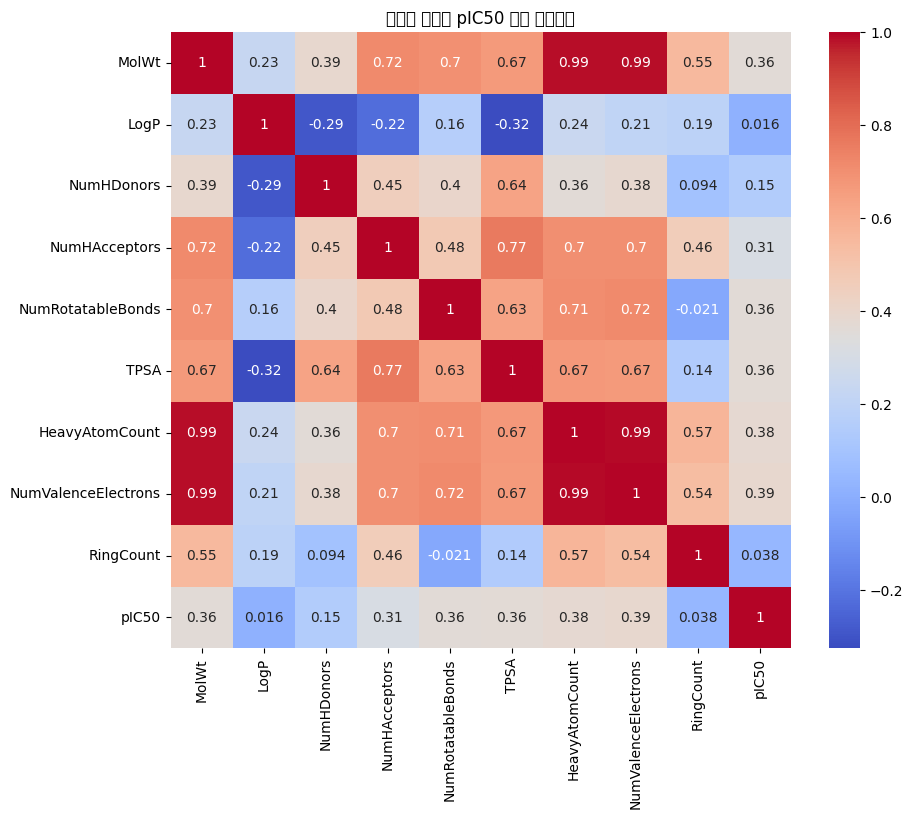

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 상관관계를 보고 싶은 피처만 선택 (화학적 피처 + pIC50)
chemical_features = ['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors', 'NumRotatableBonds',
                     'TPSA', 'HeavyAtomCount', 'NumValenceElectrons', 'RingCount', 'pIC50']

# 화학적 피처와 pIC50 간 상관관계 확인
correlation_matrix = train_combined[chemical_features].corr()

# 상관관계 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("화학적 특성과 pIC50 간의 상관관계")
plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler

# 정규화를 위한 StandardScaler 인스턴스 생성
scaler = StandardScaler()

# 상관관계가 높은 피처만 선택하여 정규화 수행
train_combined[['MolWt', 'NumValenceElectrons', 'HeavyAtomCount', 'TPSA', 'NumRotatableBonds']] = scaler.fit_transform(
    train_combined[['MolWt', 'NumValenceElectrons', 'HeavyAtomCount', 'TPSA', 'NumRotatableBonds']]
)

In [ ]:
# PyTorch Geometric Dataset 준비
dataset = []
for i, data in train_combined.iterrows():
    graph = data['graph']
    graph.y = torch.tensor([data['pIC50']], dtype=torch.float)

    # 상관관계가 높은 화학적 피처만 선택
    graph.chemical_features = torch.tensor([
        data['MolWt'],
        data['NumValenceElectrons'],
        data['HeavyAtomCount'],
        data['TPSA'],
        data['NumRotatableBonds']
    ], dtype=torch.float)

    dataset.append(graph)


In [ ]:
train_dataset, val_dataset = train_test_split(dataset, test_size=0.3, random_state=CFG['SEED'])
train_loader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False)

In [ ]:
# class MultiModalGATModel(torch.nn.Module):
#     def __init__(self):
#         super(MultiModalGATModel, self).__init__()
#         # GATConv 레이어
#         self.conv1 = GATConv(1, 64, heads=8, dropout=CFG['DROPOUT'])
#         self.conv2 = GATConv(512, 128, heads=8, dropout=CFG['DROPOUT'])

#         # 화학적 속성 피처를 처리할 선형 레이어
#         self.chem_fc1 = torch.nn.Linear(4, 64)  # 4개의 화학적 속성 입력 (MW, LogP, 등)

#         # GATConv 출력과 화학적 속성을 결합할 레이어
#         self.fc1 = torch.nn.Linear(128 * 8 + 64, 64)  # GATConv 출력과 화학적 속성 결합
#         self.fc2 = torch.nn.Linear(64, 1)

#     def forward(self, data):
#         # GATConv를 이용한 그래프 정보 처리
#         x, edge_index = data.x, data.edge_index
#         x = self.conv1(x, edge_index)
#         x = F.elu(x)
#         x = self.conv2(x, edge_index)
#         x = global_mean_pool(x, data.batch)  # 배치마다 평균 풀링 수행

#         # 화학적 속성 처리
#         chem_features = data.chemical_features  # 배치 크기에 맞추어 화학적 속성 처리
#         chem_features = chem_features.view(data.num_graphs, -1)  # 그래프 배치 크기와 일치하게 차원 조정
#         chem_out = F.relu(self.chem_fc1(chem_features))  # 화학적 속성 처리

#         # 차원 출력 확인
#         # print(f"Graph output shape: {x.shape}, Chemical feature output shape: {chem_out.shape}")

#         # 그래프 정보와 화학적 속성 결합
#         combined = torch.cat([x, chem_out], dim=1)  # 그래프 출력과 화학적 속성 결합
#         combined = F.relu(self.fc1(combined))
#         combined = F.dropout(combined, p=CFG['DROPOUT'], training=self.training)
#         out = self.fc2(combined)

#         return out

class MultiModalGATModel(torch.nn.Module):
    def __init__(self):
        super(MultiModalGATModel, self).__init__()
        # GATConv 레이어
        self.conv1 = GATConv(1, 64, heads=8, dropout=CFG['DROPOUT'])
        self.conv2 = GATConv(512, 128, heads=8, dropout=CFG['DROPOUT'])

        # 화학적 속성 피처를 처리할 선형 레이어
        self.chem_fc1 = torch.nn.Linear(5, 64)  # 9개의 화학적 속성 입력 (QSAR descriptors)

        # GATConv 출력과 화학적 속성을 결합할 레이어
        self.fc1 = torch.nn.Linear(128 * 8 + 64, 64)  # GATConv 출력과 화학적 속성 결합
        self.fc2 = torch.nn.Linear(64, 1)

    def forward(self, data):
        # GATConv를 이용한 그래프 정보 처리
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, data.batch)  # 배치마다 평균 풀링 수행

        # 화학적 속성 처리
        chem_features = data.chemical_features  # 배치 크기에 맞추어 화학적 속성 처리
        chem_features = chem_features.view(data.num_graphs, -1)  # 그래프 배치 크기와 일치하게 차원 조정
        chem_out = F.relu(self.chem_fc1(chem_features))  # 화학적 속성 처리

        # 그래프 정보와 화학적 속성 결합
        combined = torch.cat([x, chem_out], dim=1)  # 그래프 출력과 화학적 속성 결합
        combined = F.relu(self.fc1(combined))
        combined = F.dropout(combined, p=CFG['DROPOUT'], training=self.training)
        out = self.fc2(combined)

        return out


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiModalGATModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=CFG['LR'])

In [ ]:
# 가중치 초기화 함수
def initialize_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_normal_(m.weight.data)
    elif isinstance(m, GATConv):
        for param in m.parameters():
            if param.dim() > 1:
                torch.nn.init.xavier_normal_(param.data)

model.apply(initialize_weights)

MultiModalGATModel(
  (conv1): GATConv(1, 64, heads=8)
  (conv2): GATConv(512, 128, heads=8)
  (chem_fc1): Linear(in_features=5, out_features=64, bias=True)
  (fc1): Linear(in_features=1088, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
# 학습 함수 정의
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, data.y.view(-1, 1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

# 평가 함수 정의
def evaluate(loader):
    model.eval()
    predictions, targets = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            output = model(data)
            predictions.append(output.cpu())
            targets.append(data.y.view(-1, 1).cpu())
    return torch.cat(predictions), torch.cat(targets)

In [ ]:
# 조기 종료 설정
best_val_rmse = float('-inf')
patience = 0

In [ ]:
# Normalized RMSE 계산 함수
def calculate_normalized_rmse(y_true, y_pred):
    y_true_ic50 = pIC50_to_IC50_nM(y_true)  # pIC50을 IC50으로 변환
    y_pred_ic50 = pIC50_to_IC50_nM(y_pred)

    mse = mean_squared_error(y_true_ic50, y_pred_ic50)
    rmse = np.sqrt(mse)

    # torch.max와 torch.min 사용
    normalized_rmse = rmse / (torch.max(y_true_ic50) - torch.min(y_true_ic50)).item()
    return normalized_rmse

# Correct Ratio 계산 함수
def calculate_correct_ratio(y_true, y_pred):
    correct_count = torch.sum(torch.abs(y_true - y_pred) <= 0.5)
    total_count = len(y_true)
    return correct_count.item() / total_count

In [ ]:
def pIC50_to_IC50_nM(pIC50_values):
    return 10**(-pIC50_values) * 1e9

In [ ]:
for epoch in range(1, CFG['EPOCHS'] + 1):
    # 학습
    loss = train()

    # 검증
    val_pred, val_true = evaluate(val_loader)

    # Normalized RMSE 및 Correct Ratio 계산
    normalized_rmse = calculate_normalized_rmse(val_true, val_pred)
    correct_ratio = calculate_correct_ratio(val_true, val_pred)

    # 최종 점수 계산
    final_score = 0.5 * (1 - min(normalized_rmse, 1)) + 0.5 * correct_ratio

    print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Validation Normalized RMSE: {normalized_rmse:.4f}, '
          f'Correct Ratio: {correct_ratio:.4f}, Final Score: {final_score:.4f}')

    # 조기 종료 확인 (최종 점수를 기준으로)
    if final_score > best_val_rmse:  # final_score가 높을수록 좋음
        best_val_rmse = final_score
        patience = 0  # 조기 종료 patience 초기화
        torch.save(model.state_dict(), 'best_model.pth')  # 가장 좋은 모델 저장
    else:
        patience += 1
        if patience >= CFG['PATIENCE']:
            print("Early stopping")
            break

# 최종 모델 로드
model.load_state_dict(torch.load('best_model.pth'))

Epoch 001, Loss: 2.4500, Validation Normalized RMSE: 0.0792, Correct Ratio: 0.3635, Final Score: 0.6421
Epoch 002, Loss: 2.5043, Validation Normalized RMSE: 0.0795, Correct Ratio: 0.4078, Final Score: 0.6642
Epoch 003, Loss: 2.5047, Validation Normalized RMSE: 0.0797, Correct Ratio: 0.4454, Final Score: 0.6829
Epoch 004, Loss: 2.5840, Validation Normalized RMSE: 0.0792, Correct Ratio: 0.3891, Final Score: 0.6550
Epoch 005, Loss: 2.7394, Validation Normalized RMSE: 0.0782, Correct Ratio: 0.2662, Final Score: 0.5940
Epoch 006, Loss: 2.4293, Validation Normalized RMSE: 0.0797, Correct Ratio: 0.4693, Final Score: 0.6948
Epoch 007, Loss: 2.5808, Validation Normalized RMSE: 0.0789, Correct Ratio: 0.3464, Final Score: 0.6337
Epoch 008, Loss: 2.4412, Validation Normalized RMSE: 0.0795, Correct Ratio: 0.4573, Final Score: 0.6889
Epoch 009, Loss: 2.5322, Validation Normalized RMSE: 0.0795, Correct Ratio: 0.4505, Final Score: 0.6855
Epoch 010, Loss: 2.6036, Validation Normalized RMSE: 0.0786, Cor

<ipython-input-29-8910a478b88c>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

In [ ]:
def calculate_correct_ratio(y_true, y_pred):
    correct_count = np.sum(np.abs(y_true - y_pred) <= 0.5)
    total_count = len(y_true)
    return correct_count / total_count

In [ ]:
# test_lipinski = lipinski(test.Smiles)
# test_combined = pd.concat([test,test_lipinski], axis=1)
test_QSAR = calculate_qsar_descriptors(test.Smiles)
test_combined = pd.concat([test,test_QSAR], axis=1)
test_combined['graph'] = test_combined['Smiles'].apply(smiles_to_graph)

In [ ]:
test_combined[['MolWt', 'NumValenceElectrons', 'HeavyAtomCount', 'TPSA', 'NumRotatableBonds']] = scaler.fit_transform(
    test_combined[['MolWt', 'NumValenceElectrons', 'HeavyAtomCount', 'TPSA', 'NumRotatableBonds']]
)

In [ ]:
# PyTorch Geometric Dataset 준비
test_dataset = []
for i, data in test_combined.iterrows():
    graph = data['graph']
    graph.chemical_features = torch.tensor([
        data['MolWt'],
        data['NumValenceElectrons'],
        data['HeavyAtomCount'],
        data['TPSA'],
        data['NumRotatableBonds']
    ], dtype=torch.float)
    test_dataset.append(graph)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False)

In [ ]:
# 테스트 데이터 예측 수행
def predict(loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            output = model(data)
            predictions.append(output.cpu())
    return torch.cat(predictions)

test_pred = predict(test_loader)

In [ ]:
predicted_IC50_nM = pIC50_to_IC50_nM(test_pred)
submit = pd.read_csv(os.path.join(ROOT_DIR, 'sample_submission.csv'))
submit['IC50_nM'] = predicted_IC50_nM
submit

,ID,IC50_nM
0,TEST_000,18.140882
1,TEST_001,31.991945
2,TEST_002,37.424202
3,TEST_003,5.138455
4,TEST_004,17.988180
...,...,...
108,TEST_108,38.789536
109,TEST_109,5.296960
110,TEST_110,28.616650
111,TEST_111,113.505402


In [ ]:
submit.to_csv('GAT+QSAR+CORR_2.csv', index=False)